In [12]:
import numpy as np
import pandas as pd
from pandas.io.data import DataReader
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

## Obtain Data from Data Vendor

In this example, we'll get the Data from Yahoo Finance. This can be done simply by using a package from pandas.io.data. Pandas package will automatically put stock market data into nice-looking table format that is easy to analyze. We also include the plot to show what data basically look like.

In [13]:
# Get the equities data specified in symbols_list
symbols_list = ['AAPL']
data = {}
for ticker in symbols_list:
    data[ticker] = DataReader(ticker, "yahoo", '2015-01-01') # Start from 2015-Jan-01

In [14]:
# Example of obtained data
data['AAPL'].head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,111.389999,111.440002,107.349998,109.330002,53204600,105.698620
2015-01-05,108.290001,108.650002,105.410004,106.250000,64285500,102.720920
2015-01-06,106.540001,107.430000,104.629997,106.260002,65797100,102.730590
2015-01-07,107.199997,108.199997,106.699997,107.750000,40105900,104.171098
2015-01-08,109.230003,112.150002,108.699997,111.889999,59364500,108.173588


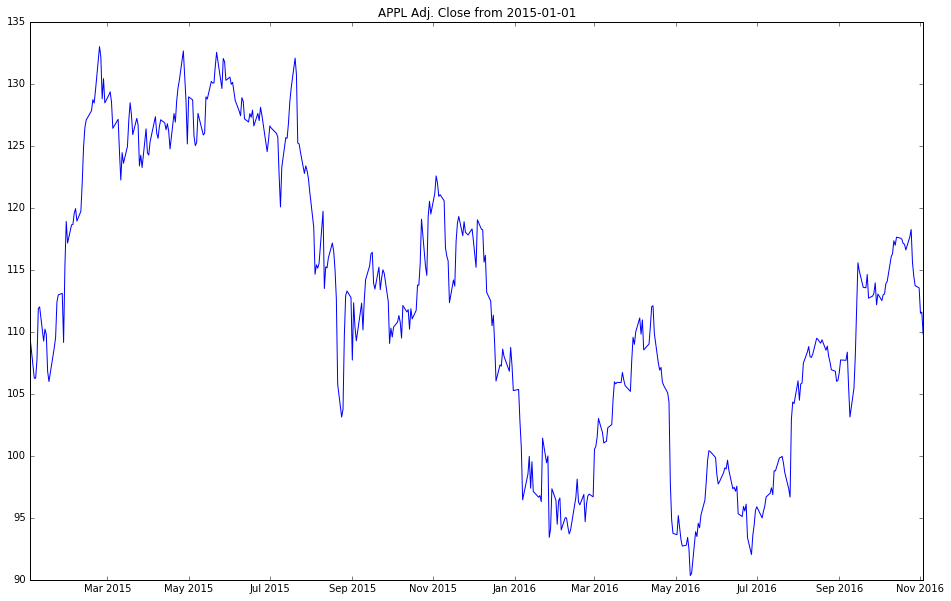

In [15]:
# Plot of AAPL Adj. Close
plt.figure(figsize=(16,10))
plt.title("APPL Adj. Close from 2015-01-01")
plt.plot(data['AAPL']['Close'])
plt.show()

# Find the current state

To use Markov Chain Model, we need to be able to tell the current state of the market given on the particular day, given that we've seen the historical data up to that particular date.

__Example Basic Ideas:__ 
*(can be changed or adjusted)*
- Look at two days before (say __day-2__, __day-1__, __day__)
    - If day-2 value < day-1 value and day-1 value < today's value, the market is __bull__(+).
    - Else if day-2 value > day-1 value and day-1 value > today's value, the market is __bear__(-).
    - Else the market is __stagnant__(0).

### Readjust the data

- Drop unneeded columns.
- Add day-1 and day-2

In [16]:
raw_data = data
processed_data = data['AAPL'][:]

del processed_data['Open']
del processed_data['High']
del processed_data['Low']
del processed_data['Close']
del processed_data['Volume']


# Add Columns for previous dates data
processed_data['day-1'] = processed_data['Adj Close'].shift(1)
processed_data['day-2'] = processed_data['Adj Close'].shift(2)

processed_data.head()

/Users/teerapatjenrungrot/anaconda3/envs/test/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/teerapatjenrungrot/anaconda3/envs/test/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Adj Close,day-1,day-2
Date,,,
2015-01-02,105.698620,NaN,NaN
2015-01-05,102.720920,105.698620,NaN
2015-01-06,102.730590,102.720920,105.69862
2015-01-07,104.171098,102.730590,102.72092
2015-01-08,108.173588,104.171098,102.73059


### Estimate the current state function

In [17]:
def estimateCurrentState(params):
    if pd.isnull(params['day-1']) or pd.isnull(params['day-2']):
        raise ValueError('Doesn\'t have previous date data')
    
    if params['day-2'] < params['day-1'] and params['day-1'] < params['Adj Close']:
        return {'bull': 0.80, 'bear': 0.15, 'stagnant': 0.05}
    elif params['day-2'] > params['day-1'] and params['day-1'] > params['Adj Close']:
        return {"bear": 0.80, 'bull': 0.15, 'stagnant': 0.05}
    else:
        return {'bull': 0.2, 'bear':0.2, 'stagnant': 0.6}

## Create the transition Matrix
__Basic Ideas__:
- Count how many times each state changes to other states, including itself.
- Convert this to probability

In [18]:
# Start at 1 to prevent dividing by zero
counter_table = {
    'bear': {
        'bear': 1,
        'bull': 1,
        'stagnant': 1,
    },
    'bull': {
        'bear': 1,
        'bull': 1,
        'stagnant': 1,
    },
    'stagnant': {
        'bear': 1,
        'bull': 1,
        'stagnant': 1,
    }
}

transition_matrix = {
    'bear': {
        'bear': 0,
        'bull': 0,
        'stagnant': 0,
    },
    'bull': {
        'bear': 0,
        'bull': 0,
        'stagnant': 0,
    },
    'stagnant': {
        'bear': 0,
        'bull': 0,
        'stagnant': 0,
    }
}

# Update Table and Prediction
__update_table()__: Given you have a table counting how many times each state changes to other states. We update the transition matrix correspondingly. 

__predict(state)__: Given the set of states together with their corresponding probability, predict the next state.

In [19]:
def update_table():
    for key in counter_table:
        bear = counter_table[key]['bear']
        bull = counter_table[key]['bull']
        stagnant = counter_table[key]['stagnant']
        total = bear + bull + stagnant
        
        transition_matrix[key]['bear'] = bear/total
        transition_matrix[key]['bull'] = bull/total
        transition_matrix[key]['stagnant'] = stagnant/total
        
def predict(state):
    """
    This can be optimized, but I hard code this so it's easy to understand.
    """
    bear = state['bear'] * transition_matrix['bear']['bear'] + \
           state['bull'] * transition_matrix['bull']['bear'] + \
           state['stagnant'] * transition_matrix['stagnant']['bear'] 
    
    bull = state['bear'] * transition_matrix['bear']['bull'] + \
           state['bull'] * transition_matrix['bull']['bull'] + \
           state['stagnant'] * transition_matrix['stagnant']['bull'] 
            
    stagnant = state['bear'] * transition_matrix['bear']['stagnant'] + \
           state['bull'] * transition_matrix['bull']['stagnant'] + \
           state['stagnant'] * transition_matrix['stagnant']['stagnant'] 
    
    return {'bear': bear, 'bull': bull, 'stagnant': stagnant}

# Simulate

Now, we'll try our models on AAPL stock data since 2015-01-01.

In [20]:
previous_state = ""
current_state = ""
prediction = ""
no_correct = 0
no_incorrect = 0
date_list = []
prediction_rate_list = []

for x,row in processed_data.iterrows():
    
    # Use the data from January 1, 2015 to May 31, 2016 to train transition matrix.
    if(x < datetime.datetime(2016, 6, 1)):
        try:
            previous_state = current_state

            current_state = estimateCurrentState(row)
            current_state = max(current_state, key=lambda x: current_state[x])

            if previous_state != "":
                counter_table[previous_state][current_state] += 1
                update_table()
        except ValueError:
            continue
    
    # Starting form June 1, 2016, we'll also predict the trend of the market.
    else:
        try:
            previous_state = current_state
            current_state = estimateCurrentState(row)
            current_state = max(current_state, key=lambda x: current_state[x])

            if previous_state != "":
                counter_table[previous_state][current_state] += 1
                update_table()
             
            if prediction != "":
                if max(prediction, key=lambda x: prediction[x]) == current_state:
                    if no_correct + no_incorrect > 0:
                        print("[Yesterday's Prediction is correct] Cumulative Prediction Rate: {}".format(no_correct/(no_correct + no_incorrect)))
                        date_list.append(x.date())
                        prediction_rate_list.append(no_correct/(no_correct + no_incorrect))
                    no_correct += 1
                else:
                    if no_correct + no_incorrect > 0:
                        print("[Yesterday's Prediction is incorrect] Cumulative Prediction Rate: {}".format(no_correct/(no_correct + no_incorrect)))
                        date_list.append(x.date())
                        prediction_rate_list.append(no_correct/(no_correct + no_incorrect))
                    no_incorrect += 1
        
            prediction = predict(estimateCurrentState(row))
            print("Today is {} with state {}".format(x.date(), estimateCurrentState(row)))
            print("==> Tomorrow will be {}".format(prediction))
            print("")

        except ValueError:
            continue
        

Today is 2016-06-01 with state {'bear': 0.8, 'stagnant': 0.05, 'bull': 0.15}
==> Tomorrow will be {'bear': 0.3656749677565399, 'stagnant': 0.5405831280418194, 'bull': 0.09374190420164075}

Today is 2016-06-02 with state {'bear': 0.8, 'stagnant': 0.05, 'bull': 0.15}
==> Tomorrow will be {'bear': 0.3706687255592864, 'stagnant': 0.5356892453951277, 'bull': 0.0936420290455858}

[Yesterday's Prediction is correct] Cumulative Prediction Rate: 0.0
Today is 2016-06-03 with state {'bear': 0.2, 'stagnant': 0.6, 'bull': 0.2}
==> Tomorrow will be {'bear': 0.2506654767940678, 'stagnant': 0.5114943879649763, 'bull': 0.23784013524095604}

[Yesterday's Prediction is incorrect] Cumulative Prediction Rate: 0.5
Today is 2016-06-06 with state {'bear': 0.15, 'stagnant': 0.05, 'bull': 0.8}
==> Tomorrow will be {'bear': 0.08853426385588682, 'stagnant': 0.5074175824175824, 'bull': 0.40404815372653075}

[Yesterday's Prediction is incorrect] Cumulative Prediction Rate: 0.3333333333333333
Today is 2016-06-07 wit

## Results

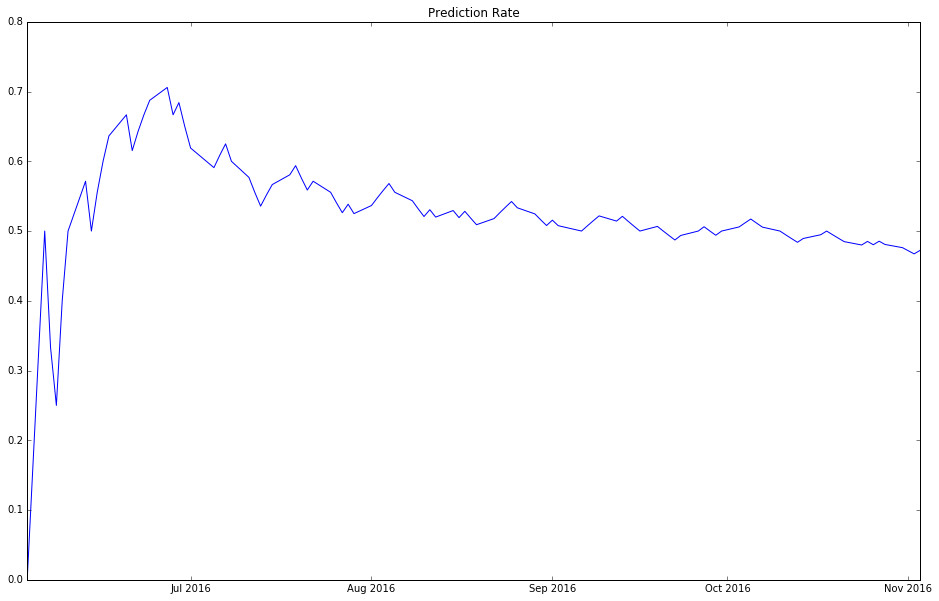

In [11]:
# Plot of Prediction Rate
plt.figure(figsize=(16,10))
plt.title("Prediction Rate")
plt.plot(date_list, prediction_rate_list)
plt.show()

## Further works

- Find the better way to define state.
- Include more parameters.
- Use Hidden Markov Models to add any other hidden variables.